In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import quaternion
import trimesh
from PIL import Image
from trimesh import load as load_model, viewer
import torch

device = 'cuda' if torch.backends.cuda.is_built() else 'cpu'

dict_keys(['trs', 'n_aligned_models', 'aligned_models', 'id_alignment', 'id_scan'])


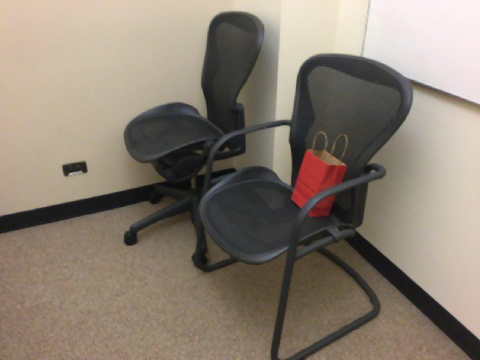

In [2]:
intr_file = '../samples/scannet_0470_00_intr.txt'
pose_file = '../samples/scannet_0470_00_0_pose.txt'
img_file = '../samples/scannet_0470_00_0.jpg'
data_file = '../samples/annot.json'

with open(intr_file) as f:
    intr = np.array([
        [float(w) for w in l.strip().split()]
        for l in f
    ])

with open(pose_file) as f:
    pose = np.array([
        [float(w) for w in l.strip().split()]
        for l in f
    ])

with open(data_file) as f:
    annot = json.load(f)[0]

img = Image.open(img_file)

# print(intr)
# print(pose)
print(annot.keys())

img

In [3]:
def make_M_from_tqs(t: list, q: list, s: list, center=None) -> np.ndarray:
    if not isinstance(q, np.quaternion):
        q = np.quaternion(q[0], q[1], q[2], q[3])
    T = np.eye(4)
    T[0:3, 3] = t
    R = np.eye(4)
    R[0:3, 0:3] = quaternion.as_rotation_matrix(q)
    S = np.eye(4)
    S[0:3, 0:3] = np.diag(s)

    C = np.eye(4)
    if center is not None:
        C[0:3, 3] = center

    M = T.dot(R).dot(S).dot(C)
    return M

models = []
for model in annot['aligned_models']:
    alignment = make_M_from_tqs(
        model['trs']['translation'],
        model['trs']['rotation'],
        model['trs']['scale']
    )
    # Normally this should include cat ids
    with open('../samples/Meshes/{}/models/model_normalized.obj'.format(model['id_cad'])) as f:
        model = load_model(file_obj=f, file_type='obj', force='mesh', process=False)

    model.apply_transform(alignment)
    models.append(model)

scene = trimesh.Scene([m.copy() for m in models])
viewer.notebook.scene_to_notebook(scene)

In [4]:
from pytorch3d.structures import Meshes, join_meshes_as_batch

def trimesh_to_pytorch3d(mesh: trimesh.Trimesh) -> Meshes:
    verts = torch.tensor(mesh.vertices, dtype=torch.float32)
    faces = torch.tensor(mesh.faces, dtype=torch.int64)
    return Meshes(verts=[verts], faces=[faces])

pt3d_mesh = join_meshes_as_batch([trimesh_to_pytorch3d(m) for m in models])
pt3d_mesh = pt3d_mesh.to(device)

In [5]:

from pytorch3d.renderer import MeshRasterizer, RasterizationSettings
from pytorch3d.utils.camera_conversions import _cameras_from_opencv_projection as opencv_camera

to_scannet = np.linalg.inv(make_M_from_tqs(
    annot['trs']['translation'],
    annot['trs']['rotation'],
    annot['trs']['scale']
))
to_cam = np.linalg.inv(pose) @ to_scannet
pose = to_cam
raster = MeshRasterizer(
    cameras=opencv_camera(
        R=torch.as_tensor(pose[:3, :3], dtype=torch.float32, device=device)[None],
        tvec=torch.as_tensor(pose[:3, 3], dtype=torch.float32, device=device)[None],
        camera_matrix=torch.as_tensor(intr[:3, :3], dtype=torch.float32, device=device)[None],
        image_size=torch.as_tensor([img.height, img.width], device=device)[None],
    ),
    raster_settings=RasterizationSettings(
        image_size=(img.height, img.width),
        # faces_per_pixel=1,
        # bin_size=None,
        # max_faces_per_bin=None,
        # perspective_correct=True,
        cull_backfaces=False,
    )
)
raster = raster.to(device)

result = raster(pt3d_mesh)

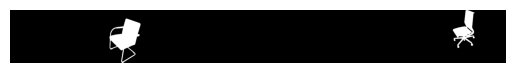

In [6]:
masks = np.hstack([z.squeeze().numpy() for z in result.zbuf > 0])
plt.axis('off')
plt.imshow(masks, cmap='gray')

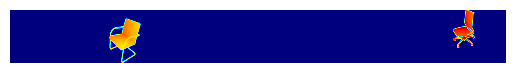

In [7]:
depths = np.hstack([z.squeeze().numpy() for z in result.zbuf])
plt.axis('off')
plt.imshow(depths, cmap='jet')

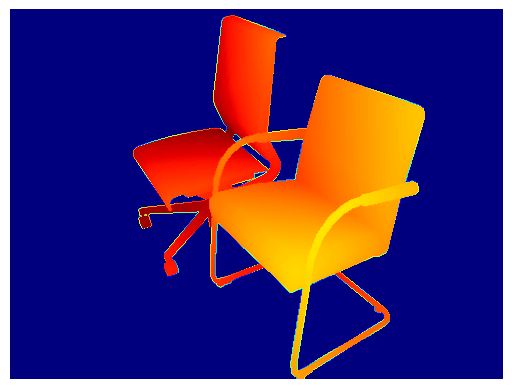

In [8]:
z = result.zbuf.clone()
z[z < 0] = torch.inf
min_idx = torch.argmin(z, dim=0, keepdim=True)
depth = torch.gather(result.zbuf, 0, min_idx)
depth[torch.isinf(depth)] = 0.0
plt.axis('off')
plt.imshow(depth.squeeze().cpu().numpy(), cmap='jet')

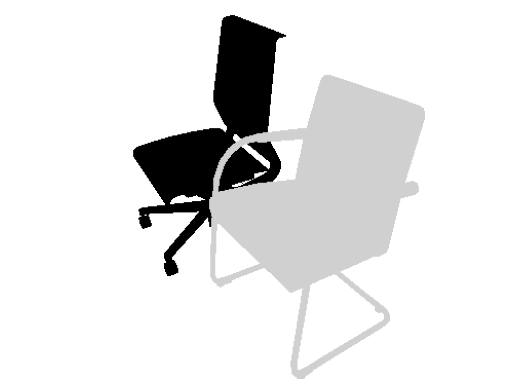

In [9]:
idx = torch.arange(1, result.zbuf.shape[0] + 1, device=device).view(-1, 1, 1, 1).expand_as(result.zbuf)
idx = torch.gather(idx, 0, min_idx)
idx *= (result.zbuf > 0).any(0)
plt.axis('off')
plt.imshow(idx.squeeze().cpu().numpy(), cmap='Greys')

<b>Overlay</b>

We now perform overlaid rendering for visualization purposes

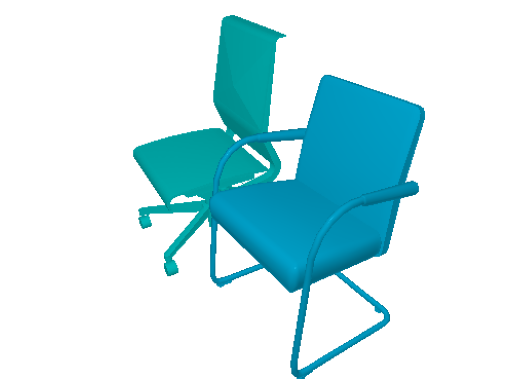

In [10]:
from pytorch3d.renderer import (
    MeshRenderer, MeshRasterizer, RasterizationSettings,
    SoftPhongShader, PointLights, Materials, TexturesVertex
)
from pytorch3d.structures import join_meshes_as_scene


model_idx = torch.unique(idx).tolist()
visible_models = [m for i, m in enumerate(models) if (i + 1) in model_idx]
pt3d_scene = [trimesh_to_pytorch3d(m) for m in visible_models]


def paint_color(mesh: Meshes, color: list) -> Meshes:
    """
    Assign a uniform color to the mesh vertices.
    """
    verts_rgb = torch.full_like(mesh.verts_padded()[..., :3], 1.)
    verts_rgb[..., :3] = torch.tensor(color, dtype=torch.float32, device=device)
    mesh.textures = TexturesVertex(verts_features=verts_rgb)


paint_color(pt3d_scene[0], [0, 0.8, 1])
paint_color(pt3d_scene[1], [0, 0.9, 0.9])
pt3d_scene = join_meshes_as_scene(pt3d_scene).to(device)

# Create white directional lights
lights = PointLights(device=device)  # , location=[[0.0, 0.0, -1.0]])

# Create a metallic material (high metallic, low roughness)
materials = Materials(
    # device=device,
    specular_color=[[0.8, 0.8, 0.8]],
    shininess=100.0,
    # metallic=1.0,
    # roughness=0.1
    device=device,
)

raster = MeshRasterizer(
    cameras=opencv_camera(
        R=torch.as_tensor(pose[:3, :3], dtype=torch.float32, device=device)[None],
        tvec=torch.as_tensor(pose[:3, 3], dtype=torch.float32, device=device)[None],
        camera_matrix=torch.as_tensor(intr[:3, :3], dtype=torch.float32, device=device)[None],
        image_size=torch.as_tensor([img.height, img.width], device=device)[None],
    ),
    raster_settings=RasterizationSettings(
        image_size=(img.height, img.width),
        faces_per_pixel=3,
        # bin_size=None,
        # max_faces_per_bin=None,
        # blur_radius=0.1,
        perspective_correct=False,
        cull_backfaces=True,
    )
)

renderer = MeshRenderer(
    rasterizer=raster,
    shader=SoftPhongShader(
        device=device,
        cameras=raster.cameras,
        lights=lights,
        materials=materials,
        blend_params=None
    )
)

# pt3d_scene.verts_normals_packed()

image = renderer(pt3d_scene)
image_arrray = image.cpu().numpy() * 255
plt.axis('off')
plt.imshow(image_arrray[0, ..., :3].astype(np.uint8))  # Display the RGB channels

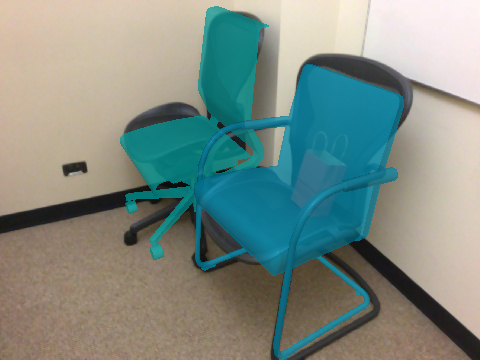

In [11]:
img_array = np.array(img, copy=True)
mask = image[0, ..., 3] > 0
img_array[mask] = (0.3 * img_array[mask] + 0.7 * image_arrray[0, mask, :3]).clip(0, 255).astype(np.uint8)
Image.fromarray(img_array)